# Abalone Age Prediction Using Non-Linear Regression - Part 2

This notebook implements Step Function and Cubic Spline regression models to predict the number of rings (age) in the Abalone dataset using non-linear modeling techniques.

In [10]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Load libraries 
- Import necessary libraries for data processing, modeling, evaluation, and visualization

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_log_error
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt


## Load datasets
- Load the training and test datasets

In [12]:
# Load the train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


## Step Function Regression 
- Build a model with the Step Function nonlinearity method

In [13]:
# STEP FUNCTION REGRESSION

# Identify quartiles for Shell weight
quantiles = train['Shell weight'].quantile([0.25, 0.5, 0.75]).values

# Create step indicators
def step_indicators(df, col):
    df = df.copy()
    df['Q1'] = np.where(df[col] <= quantiles[0], 1, 0)
    df['Q2'] = np.where((df[col] > quantiles[0]) & (df[col] <= quantiles[1]), 1, 0)
    df['Q3'] = np.where((df[col] > quantiles[1]) & (df[col] <= quantiles[2]), 1, 0)
    df['Q4'] = np.where(df[col] > quantiles[2], 1, 0)
    return df

X_train_step = step_indicators(train, 'Shell weight')
X_test_step = step_indicators(test, 'Shell weight')

# Build regression formula and model
formula_step = ('Rings ~ Q("Q1") + Q("Q2") + Q("Q3") + Q("Q4") + '
                'Q("Length") + Q("Diameter") + Q("Height") + '
                'Q("Whole weight") + Q("Whole weight.1") + Q("Whole weight.2")')
model_step = ols(formula_step, data=X_train_step).fit()

# Predict and export
pred_step = np.maximum(model_step.predict(X_test_step), 0)
submission_step = pd.DataFrame({
    'id': X_test_step['id'],
    'Rings': pred_step.round().astype(int)
})
submission_step.to_csv('submission_step.csv', index=False)


## Cubic Spline Regression 
- Build a model with the Cubic Spline nonlinearity method

In [14]:
# CUBIC SPLINE REGRESSION

# Function to generate cubic spline basis
def cubic_spline_basis(df, col, knots):
    df = df.copy()
    df['x'] = df[col]
    df['x2'] = df['x'] ** 2
    df['x3'] = df['x'] ** 3
    for i, k in enumerate(knots):
        df[f'knot_{i+1}'] = ((df['x'] - k).clip(lower=0)) ** 3
    return df

# Generate knots and spline basis
knots = train['Length'].quantile([0.25, 0.5, 0.75]).values
X_train_spline = cubic_spline_basis(train, 'Length', knots)
X_test_spline = cubic_spline_basis(test, 'Length', knots)

# Build and fit model
formula_spline = ('Rings ~ Q("x") + Q("x2") + Q("x3") + Q("knot_1") + Q("knot_2") + Q("knot_3") + '
                  'Q("Diameter") + Q("Height") + Q("Whole weight") + Q("Whole weight.1") + Q("Whole weight.2")')
model_spline = ols(formula_spline, data=X_train_spline).fit()

# Predict and export
pred_spline = np.maximum(model_spline.predict(X_test_spline), 0)
submission_spline = pd.DataFrame({
    'id': X_test_spline['id'],
    'Rings': pred_spline.round().astype(int)
})
submission_spline.to_csv('submission_spline.csv', index=False)


## RMSLE Evaluation 
- Evaluate each model using the metric root mean square logarithmic error (RMSLE)

In [15]:
# RMSLE EVALUATION

y_true = train['Rings']
y_pred_step = np.maximum(model_step.predict(X_train_step), 0)
y_pred_spline = np.maximum(model_spline.predict(X_train_spline), 0)

rmsle_step = np.sqrt(mean_squared_log_error(y_true, y_pred_step))
rmsle_spline = np.sqrt(mean_squared_log_error(y_true, y_pred_spline))

rmsle_df = pd.DataFrame({
    'Model': ['Step Function', 'Cubic Spline'],
    'RMSLE': [rmsle_step, rmsle_spline]
})
print(rmsle_df)


           Model     RMSLE
0  Step Function  0.172395
1   Cubic Spline  0.172148


## Visualization 
- Create a scatterplot of each and Illustrate as a comparative model performance. 

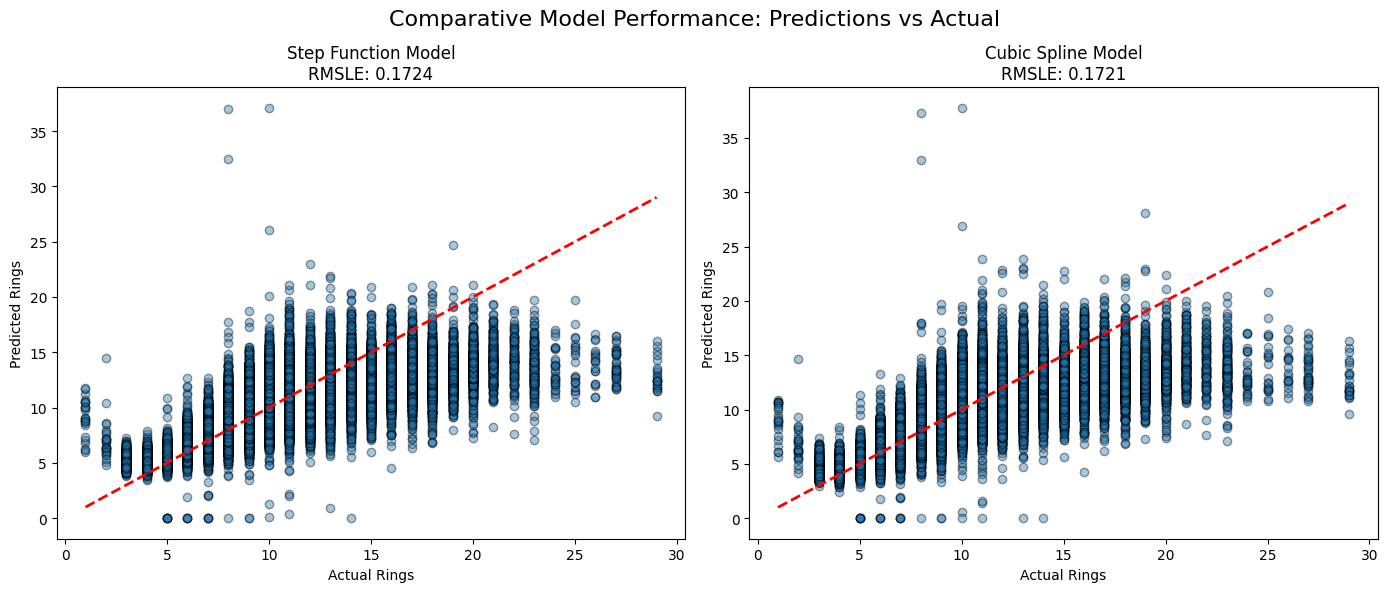

In [16]:
# VISUALIZATION

plt.figure(figsize=(14, 6))

# Step Model
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_step, alpha=0.4, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.title(f"Step Function Model\nRMSLE: {rmsle_step:.4f}")
plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")

# Spline Model
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_spline, alpha=0.4, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.title(f"Cubic Spline Model\nRMSLE: {rmsle_spline:.4f}")
plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")

plt.suptitle("Comparative Model Performance: Predictions vs Actual", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
